In [1]:
import pandas as pd



df = pd.read_csv(R"..\data-fetcher\data\total_data.csv")




### Hyperparameters

In [99]:
from math import ceil

sequence_length = 30
train_proportion = 0.5
epochs = 100
batch_size = 16
learning_rate = 0.01
data_len = len(df)//(525600//2)
hidden_size = 128
model_name = f'price_prediction_model_time_period_{data_len}_years_sequence_length_{sequence_length}_train_prop_{train_proportion}_epochs_{epochs}_batch_size_{batch_size}_lr_{learning_rate}.pth'
print(model_name)



price_prediction_model_time_period_2_years_sequence_length_30_train_prop_0.5_epochs_100_batch_size_16_lr_0.01.pth


In [90]:
def create_y(df):
    try:
        hours = [1,2,4,8]
        for hour in hours:
            df[str(hour) + '_hour'] = df.apply(lambda x: 1 if((x['hit'] - x['time']) < hour*3600) else 0 , axis = 'columns')
    except:
        print("already done")
    
def convert_to_datetime_index(df):

    try:
        df['time_epoch'] = df['time']
        df['time'] = pd.to_datetime(df['time'], unit = "s")
        df.set_index(pd.DatetimeIndex(df['time']), inplace = True)
    except:
        print("***")


def remove_weekend_data(df):# Extract day of the week and hour
    df['day_of_week'] = df['time'].index.dayofweek  # Monday=0, Sunday=6
    df['hour'] = df['time'].index.hour

    # Define the condition to remove entries between Friday 8 PM to Monday 4 AM
    condition = (
        ((df['day_of_week'] == 4) & (df['hour'] >= 20)) |  # Last 4 hours of Friday
        (df['day_of_week'] == 5) |                         # Entire Saturday
        (df['day_of_week'] == 6) |                         # Entire Sunday
        ((df['day_of_week'] == 0) & (df['hour'] < 4))      # First 4 hours of Monday
    )

    df.drop(df[condition].index, inplace=True)
    df.drop(['day_of_week','hour'], axis='columns', inplace=True)

def create_dataset(df):
    #df['close_series'] = df['close'].rolling(window=60, min_periods=1).apply(lambda x: x.tolist(), raw=False)
    #df['close_series'] = df['close'].rolling(window=60).apply(lambda x: ','.join(map(str, x)), raw=False)
    box_indices = df.index[df['target'].notnull()].to_list()
    print("len of box",len(box_indices))
    dataset = []
    count = 0
    y = []
    max_length = 0
    for i in box_indices:
        #close = [df['close'].loc[i]]
        #box_data = df[['high_reward','high_risk','low_reward','low_risk']].loc[i].to_list()
        target = df['high_reward'].loc[i] if df['direction'].loc[i] == 'Long' else df['low_reward'].loc[i]
        #prev_bars = df['close'].loc[i - pd.Timedelta(minutes = 60):i - pd.Timedelta(minutes = 1)].to_list()
        #prev_bars = df['close'].loc[i - pd.Timedelta(minutes = sequence_length - 1):i].to_list()
        #prev_ma = df['moving_average'].loc[i - pd.Timedelta(minutes = sequence_length - 1):i].to_list()
        index = df.index.get_loc(i)

        prev_bars = df['close'].iloc[index - sequence_length: index].to_list()
        prev_ma = df['moving_average'].iloc[index - sequence_length: index].to_list()
        

        #y_ = df[['1_hour','2_hour','4_hour','8_hour']].loc[i].to_list()
        y_ = df['1_hour'].loc[i]
        
        if(len(prev_bars) == sequence_length): 
            #temp = [close, box_data, prev_bars, prev_ma]
            temp = [target,prev_bars,prev_ma]
            dataset.append(temp)
            y.append(y_)
        else:
            count += 1
        
            continue
    print("count:",count)

    return dataset, y

def prepare_data(refdata):
    '''
    This function will prepare the data for the model work. It involves the following steps
    * Create y variables - when did the hit happen
    * Remove weekend data
    * Create Time series variable for each box timestamp
    * Remove rows without boxes
    '''
    create_y(refdata)
    #remove_weekend_data(refdata)
    convert_to_datetime_index(refdata)
    print(refdata.head())
    return create_dataset(refdata)


x, y = prepare_data(df)





already done
                                   time     open     high      low    close  \
time                                                                          
2023-01-02 23:40:00 2023-01-02 23:40:00  1827.64  1827.66  1827.64  1827.66   
2023-01-02 23:41:00 2023-01-02 23:41:00  1826.82  1827.87  1826.82  1827.87   
2023-01-02 23:42:00 2023-01-02 23:42:00  1827.92  1828.30  1827.23  1827.23   
2023-01-02 23:43:00 2023-01-02 23:43:00  1828.15  1828.15  1827.70  1827.70   
2023-01-02 23:44:00 2023-01-02 23:44:00  1827.91  1827.91  1827.31  1827.87   

                       color  moving_average color_moving_average  end  \
time                                                                     
2023-01-02 23:40:00      NaN       1826.4896              #26a69a  NaN   
2023-01-02 23:41:00      NaN       1826.5626              #26a69a  NaN   
2023-01-02 23:42:00      NaN       1826.5930              #26a69a  NaN   
2023-01-02 23:43:00      NaN       1826.6204              #26a6

In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(x[:10])
scaled_x


#####MODEL
This implementation includes:

A custom Dataset class for preprocessing data
An LSTM-based model architecture
Training loop with validation
Learning rate optimization with Adam
Binary cross-entropy loss
Dropout layers for regularization
Model checkpointing
The model processes the close prices through LSTM layers and combines the output with the target price before making the final prediction.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

class PriceDataset(Dataset):
    def __init__(self, X, y):
        self.scaler = MinMaxScaler()

        # Extract and scale target prices
        self.targets = np.array([x[0] for x in X]).reshape(-1, 1)
    #    self.scaled_targets = self.target_scaler.fit_transform(targets)
        
        # Extract and scale close prices
        self.closes = np.array([x[1] for x in X])
      #  self.scaled_closes = self.price_scaler.fit_transform(closes)

        #Extract and scale moving average
        self.moving = np.array([x[2] for x in X])
     #   self.scaled_moving = self.moving_scaler.fit_transform(moving)

        

        #self.paired_data = np.dstack([self.scaled_closes,self.scaled_moving])
        
        
        # Convert to tensors
        self.X = torch.FloatTensor(np.column_stack([
            self.targets,
            self.closes,
            self.moving

        ]))
        self.y = torch.FloatTensor(y)

        self.X = self.scaler.fit_transform(self.X.flatten().reshape(-1,1)).reshape(self.X.shape).astype('float32')
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class PricePredictionModel(nn.Module):
    def __init__(self, sequence_length=60, hidden_size=64):
        super(PricePredictionModel, self).__init__()
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        
        )
#        self.lstm2 = nn.LSTM(
#            input_size = hidden_size,
#            hidden_size = hidden_size // 2,
#            num_layers = 3,
#            batch_first = True,
#
#        )  
#        self.lstm3 = nn.LSTM(
#            input_size = hidden_size,
#            hidden_size = hidden_size // 2,
#            num_layers = 3,
#            batch_first = True,
#        )
#        self.lstm4 = nn.LSTM(
#            input_size = hidden_size,
#            hidden_size = hidden_size // 2,
#            num_layers = 3,
#            batch_first = True,
#        ) 

        
        self.fc1 = nn.Linear(hidden_size + 1, 128)  # +1 for target price
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32,16)
        self.fc5 = nn.Linear(16,1)
        self.sigmoid = nn.Sigmoid()
        self.leakyrelu = nn.LeakyReLU()
        
    def forward(self, x):
        # Split input into target price and close prices
        target_price = x[:, 0].unsqueeze(1)  # Shape: [batch_size, 1]
        close_prices = x[:, 1:sequence_length + 1].unsqueeze(2)   # Shape: [batch_size, sequence_length, 1]
        moving_average = x[:,sequence_length + 1:].unsqueeze(2)  # Shape: [batch_size, sequence_length, 1]

        #lstm_in = torch.dstack((close_prices,moving_average))  # Shape: [batch_size, sequence_length, 2]
        lstm_in = moving_average

        


        
        
        # Process close prices through LSTM
       # lstm_out, _ = self.lstm1(lstm_in)
       # lstm_last = lstm_out[:, -1, :]  # Take last LSTM output
        #h_out = h_out.view(-1,self.hidden_size)
       # _, (h_n, _) = self.lstm1(lstm_in)  # h_n shape: [num_layers, batch_size, hidden_size]
        lstm_out, _ = self.lstm1(lstm_in)
        lstm_last = lstm_out[:, -1, :]
       # out_2,(h_n,_ ) = self.lstm2(lstm_last)
      #  h_n = h_n[-1]

        
        # Take the hidden state from the last layer
        #lstm_hidden = h_n.permute(1, 0, 2).reshape(x.shape[0], -1)  # Shape: [batch_size, hidden_size * num_layers]
        
        # Concatenate LSTM hidden state with target price
        combined = torch.cat([lstm_last, target_price], dim=1)  # Shape: [batch_size, hidden_size * num_layers + 1]


        
 

        
        # Pass through fully connected layers
        x = self.leakyrelu(self.fc1(combined))
        x = self.dropout(x)
        x = self.leakyrelu(self.fc2(x))
        x = self.leakyrelu(self.fc3(x))
        x = self.leakyrelu(self.fc4(x))
        x = self.fc5(x)
        
      
        
        return x
grad_rows = {}
def save_gradients(model):
    global grad_rows
    


    for name,param in model.named_parameters():
        if name in grad_rows :
            grad_rows[name].append(param.grad.norm().item())
        else:
            if(param.grad is not None):
                grad_rows[name] = [param.grad.norm().item()]


        


def train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps = 0.01)
    train_loss_array = []
    val_loss_array = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            loss.backward()
            optimizer.step()
            save_gradients(model)
            
            train_loss += loss.item()
        

            
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        control_corr = 0
   

        
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs.squeeze(), batch_y).item()
                control = torch.ones(batch_y.size(0)).to(device)
                
                predicted = (torch.sigmoid(outputs).squeeze() > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted ==batch_y).sum().item()
                control_corr += (control == batch_y).sum().item()
        train_loss_array.append(train_loss/len(train_loader))
        val_loss_array.append(val_loss/len(val_loader))
                
        
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}')
        print(f'Val Accuracy: {100 * correct/total:.2f}%')
        print(f'Control Accuracy: {100 * control_corr/total:.2f}%')
        print('--------------------')
    plt.plot(np.arange(1, epochs+1),train_loss_array)
    plt.plot(np.arange(1, epochs+ 1),val_loss_array)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(labels = ['training_loss','validation_loss'])
    grad_df = pd.DataFrame(grad_rows)
    grad_df.to_csv(R"..\data-fetcher\data\gradients.csv")

In [ ]:
from torch.utils.data import random_split
import seaborn as sns
import matplotlib.pyplot as plt

dataset = PriceDataset(X=x[:500], y=y)

train_size = int(train_proportion * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)


iterator = iter(train_loader)
sample = next(iterator)








In [6]:
torch.cuda.is_available()

True

Epoch [1/100]
Train Loss: 0.7012
Val Loss: 0.6896
Val Accuracy: 55.00%
Control Accuracy: 55.00%
--------------------
Epoch [2/100]
Train Loss: 0.6951
Val Loss: 0.6906
Val Accuracy: 55.00%
Control Accuracy: 55.00%
--------------------
Epoch [3/100]
Train Loss: 0.6933
Val Loss: 0.6920
Val Accuracy: 55.00%
Control Accuracy: 55.00%
--------------------
Epoch [4/100]
Train Loss: 0.6918
Val Loss: 0.6911
Val Accuracy: 55.00%
Control Accuracy: 55.00%
--------------------
Epoch [5/100]
Train Loss: 0.6909
Val Loss: 0.6904
Val Accuracy: 55.00%
Control Accuracy: 55.00%
--------------------
Epoch [6/100]
Train Loss: 0.6928
Val Loss: 0.6899
Val Accuracy: 55.00%
Control Accuracy: 55.00%
--------------------
Epoch [7/100]
Train Loss: 0.6954
Val Loss: 0.6899
Val Accuracy: 55.00%
Control Accuracy: 55.00%
--------------------
Epoch [8/100]
Train Loss: 0.6885
Val Loss: 0.6902
Val Accuracy: 55.00%
Control Accuracy: 55.00%
--------------------
Epoch [9/100]
Train Loss: 0.6956
Val Loss: 0.6898
Val Accuracy: 

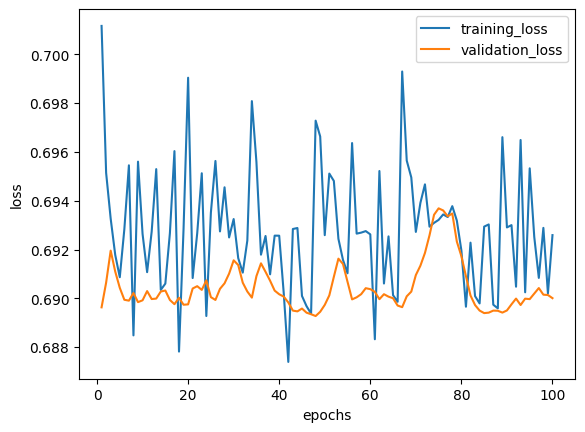

In [101]:
import torch
from torch.utils.data import random_split
#from model import PriceDataset, PricePredictionModel, train_model

# Create dataset
dataset = PriceDataset(X=x[:200], y=y[:200])

# Split dataset
train_size = int(train_proportion * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

# Initialize model
model = PricePredictionModel(sequence_length=sequence_length, hidden_size=hidden_size)

# Train model
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    learning_rate=learning_rate
)

# Save model
#torch.save(model.state_dict(), model_name)

In [ ]:
model.eval()
test_data = []
for i in test_index:
        #close = [df['close'].loc[i]]
        #box_data = df[['high_reward','high_risk','low_reward','low_risk']].loc[i].to_list()
        target = df['high_reward'].loc[i] if df['direction'].loc[i] == 'Long' else df['low_reward'].loc[i]
        #prev_bars = df['close'].loc[i - pd.Timedelta(minutes = 60):i - pd.Timedelta(minutes = 1)].to_list()
        prev_bars = df['close'].loc[i - pd.Timedelta(minutes = 59):i].to_list()
        #prev_ma = df['moving_average'].loc[i - pd.Timedelta(minutes = 60):i - pd.Timedelta(minutes = 1)].to_list()
        

        #y_ = df[['1_hour','2_hour','4_hour','8_hour']].loc[i].to_list()
        y_ = df['4_hour'].loc[i]
        
        if(len(prev_bars) == 60): 
            #temp = [close, box_data, prev_bars, prev_ma]
            temp = [target, prev_bars]
            test_data.append(temp)
            y.append(y_)
        else:
        
        
            continue


    

    

In [ ]:

test_set = PriceDataset(X = test_data, y = [0]*len(test_data) )
test_loader  = torch.utils.data.DataLoader(
    test_set, 
    batch_size=1, 
    shuffle=False
)

for Batch_X, Batch_Y in test_loader:
    Batch_X = Batch_X.to('cuda')
    print(model(Batch_X))


In [96]:
grad_rows   

{'lstm1.weight_ih_l0': [0.0013620950048789382,
  0.0009642761433497071,
  0.0009804730070754886,
  0.000691780645865947,
  0.0007610713364556432,
  0.0006555225700139999,
  0.0004820168251171708,
  0.0027095258701592684,
  0.0010940233478322625,
  0.00034278215025551617,
  0.0008625363698229194,
  0.002645430387929082,
  0.0010349615477025509,
  0.0015934936236590147,
  0.0005618237191811204,
  0.0021011673379689455,
  0.000667115265969187,
  0.0005628346116282046,
  0.0006295931525528431,
  0.002239231253042817,
  0.0012811440974473953,
  0.0005347522674128413,
  0.0005240159225650132,
  0.0012507367646321654,
  0.0009792872006073594,
  0.0006327696610242128,
  0.0008322721114382148,
  0.001915567321702838,
  0.0010544045362621546,
  0.00031907306401990354,
  0.0004916772595606744,
  0.0012878504348918796,
  0.0002929139882326126,
  0.0003684656694531441,
  0.001175194513052702,
  0.0029884735122323036,
  0.0005240010796114802,
  0.0008341303328052163,
  0.00027627486269921064,
  0.00

In [97]:
pprint(grad_rows)

{'fc1.bias': [0.009194563142955303,
              0.00884539820253849,
              0.0055344682186841965,
              0.006032941862940788,
              0.005496310535818338,
              0.0022080799099057913,
              0.003150650765746832,
              0.015912288799881935,
              0.004670129157602787,
              0.0027331002056598663,
              0.00419906061142683,
              0.024039890617132187,
              0.007508174050599337,
              0.008557332679629326,
              0.004414789378643036,
              0.008716381154954433,
              0.002631339244544506,
              0.0027341784443706274,
              0.0060153682716190815,
              0.012425140477716923,
              0.005566606298089027,
              0.00459340400993824,
              0.004068235866725445,
              0.012884560041129589,
              0.006141067948192358,
              0.003457309678196907,
              0.0031284100841730833,
              0.012986506